In [0]:
import os, cv2
from PIL import Image, ImageOps
import pickle
import imutils
from tqdm import tqdm
from time import *
import numpy as np
import math
import h5py
import timeit
from random import shuffle
import matplotlib.pyplot as plt
import keras.utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing 
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import glob

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [84]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Setting the root directory for the user

In [0]:
check_dir = os.getcwd() + '/drive/My Drive/'
if 'Academics' in os.listdir(check_dir): # Niraj drive
  root_dir = '/content/drive/My Drive/Academics/Sem1/682/'
else: # Anirudh drive
  root_dir = '/content/drive/My Drive/'

In [86]:
dataset_path = root_dir + 'CS682 Project/Final/Dataset/data_128/'
results_path = root_dir + 'CS682 Project/Final/Results/'
models_path = root_dir + 'CS682 Project/Final/Models/'

fish_path = dataset_path + 'Fish/'
bg_path = dataset_path + 'Background/'
lamprey_path = dataset_path + 'Lamprey/'

fish_img = glob.glob(f'{fish_path}*')[:]
lamprey_img = glob.glob(f'{lamprey_path}*')[:]
bg_img = glob.glob(f'{bg_path}*')[:]

print("Frequency of class labels:\n")
print("# of Fish images :", len(fish_img))
print("# of Lamprey images :", len(lamprey_img))
print("# of Background images :", len(bg_img))

Frequency of class labels:

# of Fish images : 5081
# of Lamprey images : 5110
# of Background images : 2477


**Class labels**

Background - 0 <br/>
Fish - 1 <br/>
Lamprey - 2

**Data Augmentation**:


* 2 mirrors
* 3 rotations
* grey-scale 



**Data Augmentation:**

In [0]:
def augmentData(X, y):

  X_gen, y_gen = [], []

  datagen = ImageDataGenerator(horizontal_flip = True, 
                              vertical_flip = True, 
                              featurewise_center=True,
                              featurewise_std_normalization=True)
  
  labels = np.argmax(y, axis = 1)
  fish_img, bg_img, lamprey_img = [], [], []

  # Splitting data according to classes
  for i in range(len(labels)):
    if labels[i] == 0:
      fish_img.append(X[i])
    elif labels[i] == 1:
      bg_img.append(X[i])
    else:
      lamprey_img.append(X[i])

  f = np.array(fish_img)
  b = np.array(bg_img)
  l = np.array(lamprey_img)

  # 200 indices for rotating
  ind = np.random.choice(len(f), 200)

  it = datagen.flow(f, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(0)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(0)


  it = datagen.flow(b, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(1)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(1)

  it = datagen.flow(l, batch_size = 128)
  for i in range(5):
    batch = it.next()
    for j in range(len(batch)):
      img = batch[j].astype('float')
      X_gen.append(img)
      y_gen.append(2)
  for index in ind:
    X_gen.append(np.rot90(X[index], k = index%3 + 1, axes = (0, 1)))
    y_gen.append(2)

  return np.array(X_gen), np.array(y_gen)

In [0]:
def sampleDataset(X, y, fraction):
  bg, fish, lamprey = [], [], []

  for img, label in zip(X, y):
    label = np.argmax(label, axis = 0)
    if label==0:
      bg.append((img, label))
    if label==1:
      fish.append((img, label))
    if label==2:
      lamprey.append((img, label))

  fraction = 0.8

  smol_X = []
  smol_y = []

  fish_ind = np.random.choice(len(fish), int(fraction*len(fish)))
  for ind in fish_ind:
      smol_X.append(fish[ind][0])
      smol_y.append(fish[ind][1])

  lamprey_ind = np.random.choice(len(lamprey), int(fraction*len(lamprey)))
  for ind in lamprey_ind:
      smol_X.append(lamprey[ind][0])
      smol_y.append(lamprey[ind][1])

  for img, label in bg:
    smol_X.append(img)
    smol_y.append(label)

  smol_y = to_categorical(smol_y)

  return np.array(smol_X), np.array(smol_y)

In [0]:
def load_data(data_augmentation = False, rgb2gray = False, normalize = False, fraction = 1.0):
  ''' Function to load data
  Input: Optional parameters to augment data
  Output: Returns tuple containg X_train, y_train, X_test, y_test '''

  # Reading the .h5 file
  start = time() 
  hf = h5py.File(dataset_path + "Dataset 128x128.h5", "r")
  X = np.array(hf['images']) 
  y = np.array(hf['labels']) 
  end = time() 
  hf.close() 
  print("\nTotal time taken to read %d images = %.4f seconds" % (len(X), end - start))

  if fraction < 1.0:
    X, y = sampleDataset(X, y, fraction)

  mean_pixel, std_pixel = None, None
  
  if normalize == True:
    # normalize the data by subtracting mean and dividing by std
    mean_pixel = X.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X.std(axis=(0, 1, 2), keepdims=True)
    X = (X - mean_pixel) / std_pixel

  if data_augmentation == True: 
    start = time() 
    X_gen, y_gen = augmentData(X, y) 
    y_gen = to_categorical(y_gen)
    end = time() 
    print("\nTotal time taken to augment %d images = %.4f seconds" % (len(X), end - start)) 
    X = np.concatenate((X, X_gen)) 
    y = np.concatenate((y, y_gen))
  
  if rgb2gray == True:
    X, y = rgbGray(X, y)
    X = X[ : , : , : , np.newaxis]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 158)

  print("\nDimensions of training data : ", X_train.shape, y_train.shape) 
  print("\nDimensions of test data : ", X_test.shape, y_test.shape)

  return X_train, y_train, X_test, y_test, mean_pixel, std_pixel

**Loading Dataset**

In [90]:
X_train, y_train, X_test, y_test, mean_pixel, std_pixel = load_data(normalize = True, fraction = 0.8)


Total time taken to read 12668 images = 122.1140 seconds

Dimensions of training data :  (7971, 128, 128, 3) (7971, 3)

Dimensions of test data :  (2658, 128, 128, 3) (2658, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

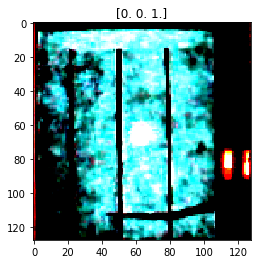

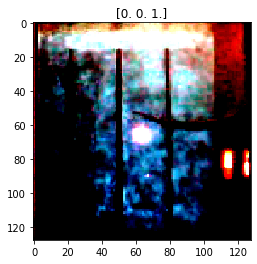

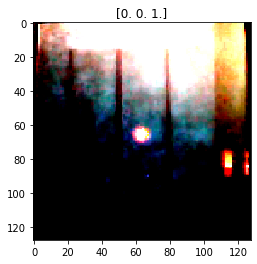

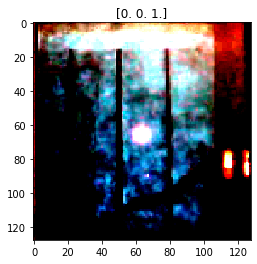

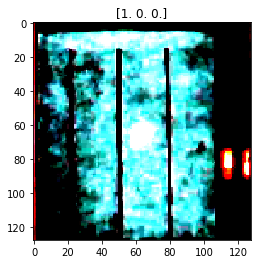

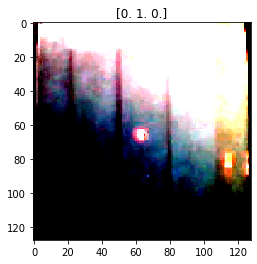

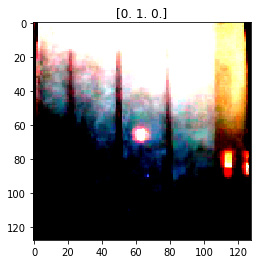

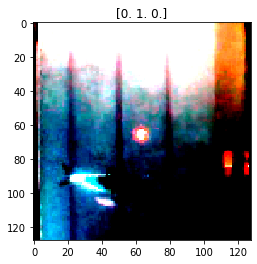

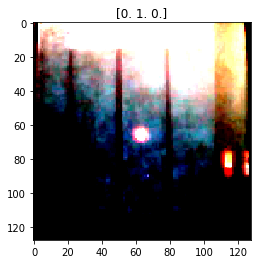

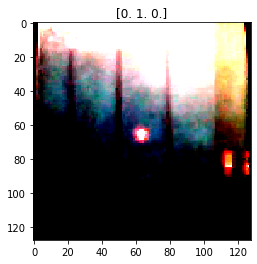

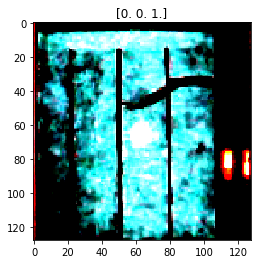

In [95]:
ct = 0
for i in range(len(X_train)):
  plt.figure()
  plt.title(y_train[230+i])
  plt.imshow(X_train[230+i])
  if ct == 10:
    break
  ct+= 1


In [0]:
# input_shape = (128, 128, 3)

# model = Sequential(name = 'baseline_128x128')

# model.add(Conv2D(32, (5, 5), input_shape = input_shape, padding = 'same', kernel_initializer = keras.initializers.lecun_uniform(seed = 158)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# model.add(Conv2D(64, (5, 5), input_shape = input_shape, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# model.add(Conv2D(128, (5, 5), padding = 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# model.add(Flatten())

# model.add(Dense(3, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=1e-5),
#               metrics=['accuracy'])

# model.summary()

model = Sequential(name = 'baseline')
model.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), padding = 'same', name = 'conv1'))
model.add(Conv2D(64, (3, 3), padding = 'same', name = 'conv2'))

model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'pool1'))

model.add(Flatten())
model.add(Dense(3, activation='softmax', name = 'fc3'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=5e-5),
              metrics=['accuracy'])

model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 128, 32)      896       
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      18496     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
fc3 (Dense)                  (None, 3)                 786435    
Total params: 805,827
Trainable params: 805,827
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpointer = keras.callbacks.ModelCheckpoint(models_path + 'LampNet_Baseline1_1(cb)_128x128.h5', 
                                               monitor='val_loss', verbose=1, 
                                               save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='auto', period=1)

history = model.fit(X_train, y_train, batch_size = 128, epochs = 100, validation_split=0.2, shuffle = True, callbacks = [checkpointer])
model.save(models_path + 'LampNet_Baseline1_1_128x128.h5')

# Saving training history
# start = time()
# hf = h5py.File(results_path + "LU_Adam(1e-5).h5", "w")
# hf.create_dataset("acc", data = history.history['acc'])
# hf.create_dataset("loss", data = history.history['loss'])
# hf.create_dataset("val_acc", data = history.history['val_acc'])
# hf.create_dataset("val_loss", data = history.history['val_loss'])
# hf.close()
# end = time()
# print("Saved training history!")

Train on 6376 samples, validate on 1595 samples
Epoch 1/100
6376/6376 [==============================] - 54s 8ms/step - loss: 0.9166 - acc: 0.6175 - val_loss: 0.6957 - val_acc: 0.6815

Epoch 00001: val_loss improved from inf to 0.69571, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline1_1(cb)_128x128.h5
Epoch 2/100
6376/6376 [==============================] - 53s 8ms/step - loss: 0.6746 - acc: 0.7188 - val_loss: 0.6253 - val_acc: 0.7248

Epoch 00002: val_loss improved from 0.69571 to 0.62529, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline1_1(cb)_128x128.h5
Epoch 3/100
6376/6376 [==============================] - 54s 8ms/step - loss: 0.5936 - acc: 0.7574 - val_loss: 0.5804 - val_acc: 0.7611

Epoch 00003: val_loss improved from 0.62529 to 0.58043, saving model to /content/drive/My Drive/CS682 Project/Final/Models/LampNet_Baseline1_1(cb)_128x128.h5
Epoch 4/100
6376/6376 [==============================] - 53s 8ms/step -

In [0]:
print("Best val_loss = {}\nBest val_acc = {}".format(min(history.history['val_loss']), max(history.history['val_acc'])))

Best val_loss = 0.2287994429609245
Best val_acc = 0.923510972123161


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


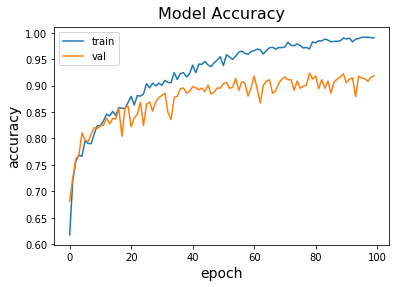

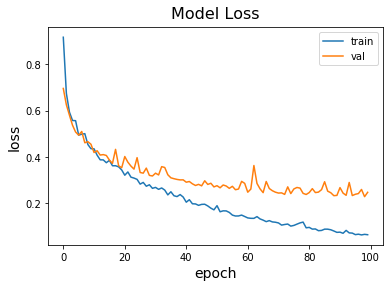

In [0]:
title_font = {'fontname':'Times', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Times', 'size':'14'}


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', **title_font)
plt.ylabel('accuracy', **axis_font)
plt.xlabel('epoch', **axis_font)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plt.savefig(results_path + 'Accuracy plot.pdf')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', **title_font)
plt.ylabel('loss', **axis_font)
plt.xlabel('epoch', **axis_font)
plt.legend(['train', 'val'], loc='upper right')
plt.show()
# plt.savefig(results_path + 'Loss plot.pdf')

In [0]:
print("############### Stats for fully trained model ###############")
model = load_model(models_path + 'LampNet_Baseline1_1_128x128.h5')

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
y_preds1 = model.predict(X_test)
ctest, preds = np.argmax(y_test, axis = 1), np.argmax(y_preds1, axis = 1)
print("Confusion matrix : ")
print(confusion_matrix(ctest, preds))

print("############### Stats for CallBack model ###############")
model = load_model(models_path + 'LampNet_Baseline1_1(cb)_128x128.h5')

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
y_preds2 = model.predict(X_test)
ctest, preds = np.argmax(y_test, axis = 1), np.argmax(y_preds2, axis = 1)
print("Confusion matrix : ")
print(confusion_matrix(ctest, preds))

############### Stats for fully trained model ###############
Test loss: 0.24783873118521846
Test accuracy: 0.918359668924003
Confusion matrix : 
[[615  12  25]
 [ 81 879  23]
 [ 59  17 947]]
############### Stats for CallBack model ###############
Test loss: 0.23316709590729598
Test accuracy: 0.9168547780285929
Confusion matrix : 
[[564  47  41]
 [ 44 919  20]
 [ 42  27 954]]


In [0]:
y_preds1 = np.argmax(y_preds1, axis = 1)
y_preds2 = np.argmax(y_preds2, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [0]:
print("############### Classification report for Fully trained model ###############")
print(classification_report(y_test, y_preds1, target_names = ['Background', 'Fish', 'Lamprey']) )

print("############### Classification report for CallBack model ###############")
print(classification_report(y_test, y_preds2, target_names = ['Background', 'Fish', 'Lamprey']) )

############### Classification report for Fully trained model ###############
              precision    recall  f1-score   support

  Background       0.81      0.94      0.87       652
        Fish       0.97      0.89      0.93       983
     Lamprey       0.95      0.93      0.94      1023

    accuracy                           0.92      2658
   macro avg       0.91      0.92      0.91      2658
weighted avg       0.92      0.92      0.92      2658

############### Classification report for CallBack model ###############
              precision    recall  f1-score   support

  Background       0.87      0.87      0.87       652
        Fish       0.93      0.93      0.93       983
     Lamprey       0.94      0.93      0.94      1023

    accuracy                           0.92      2658
   macro avg       0.91      0.91      0.91      2658
weighted avg       0.92      0.92      0.92      2658



Plotting ROC-AUC curve

In [0]:
y_probs = model.predict_proba(X_test)
y_test = to_categorical(y_test)

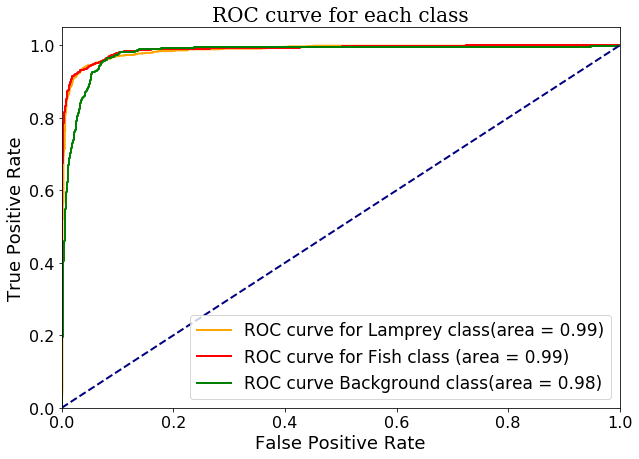

{0: 0.9798166849145815, 1: 0.9888170540987838, 2: 0.986440313164196}


In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
class_score = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    class_score[i] = roc_auc_score(y_test[:, i], y_probs[:, i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 7))
lw = 2
plt.plot(fpr[2], tpr[2], color='orange',
         lw=lw, label='ROC curve for Lamprey class(area = %0.2f)' % roc_auc[2])
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve for Fish class (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='green',
         lw=lw, label='ROC curve Background class(area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', family = 'sans-serif', size = 18)
plt.ylabel('True Positive Rate',  family = 'sans-serif', size = 18)
plt.title('ROC curve for each class', family = 'serif', size = 20, weight = 'normal')
plt.xticks(family = 'sans-serif', size = 16)
plt.yticks(family = 'sans-serif', size = 16)
plt.legend(loc="lower right", prop={'size': 17})
plt.show()
print(class_score)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

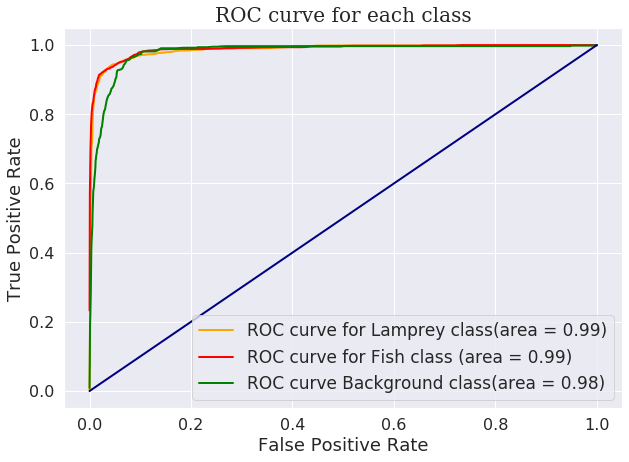

In [0]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,7)})
sns.lineplot(fpr[2], tpr[2], color='orange',
         lw=lw, label='ROC curve for Lamprey class(area = %0.2f)' % roc_auc[2])
sns.lineplot( fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve for Fish class (area = %0.2f)' % roc_auc[1])
sns.lineplot(fpr[0], tpr[0], color='green',
         lw=lw, label='ROC curve Background class(area = %0.2f)' % roc_auc[0])
sns.lineplot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc="lower right", prop={'size': 17})
plt.xlabel('False Positive Rate', family = 'sans-serif', size = 18)
plt.ylabel('True Positive Rate',  family = 'sans-serif', size = 18)
plt.title('ROC curve for each class', family = 'serif', size = 20, weight = 'normal')
plt.xticks(family = 'sans-serif', size = 16)
plt.yticks(family = 'sans-serif', size = 16)
# ax.xlim([0.0, 1.0])
# ax.ylim([0.0, 1.05])

In [0]:
print("ROC-AUC score for the model %.3f" %(roc_auc_score(y_test, y_probs)))

ROC-AUC score for the model 0.985


In [0]:
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [0]:
model = load_model(models_path + 'LampNet_Baseline2_1_128x128.h5')

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'activation_1': <keras.layers.core.Activation at 0x7f50016bf8d0>,
 'activation_2': <keras.layers.core.Activation at 0x7f4fb9df34e0>,
 'activation_3': <keras.layers.core.Activation at 0x7f50015d0860>,
 'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x7f5001608240>,
 'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7f50a3a43438>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7f50016bf278>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7f50015db908>,
 'dense_1': <keras.layers.core.Dense at 0x7f5001602550>,
 'flatten_1': <keras.layers.core.Flatten at 0x7f50015fa710>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7f50016bf908>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7f5001608e10>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x7f50015fa978>}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


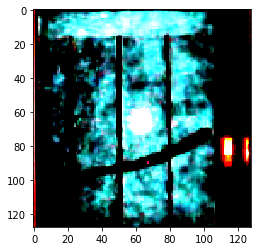

In [68]:
plt.figure()
input_img = X_test[101]
plt.imshow(input_img)

In [0]:
from matplotlib import pyplot

In [66]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'activation_1': <keras.layers.core.Activation at 0x7f50016bf8d0>,
 'activation_2': <keras.layers.core.Activation at 0x7f4fb9df34e0>,
 'activation_3': <keras.layers.core.Activation at 0x7f50015d0860>,
 'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x7f5001608240>,
 'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7f50a3a43438>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7f50016bf278>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7f50015db908>,
 'dense_1': <keras.layers.core.Dense at 0x7f5001602550>,
 'flatten_1': <keras.layers.core.Flatten at 0x7f50015fa710>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7f50016bf908>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7f5001608e10>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x7f50015fa978>}

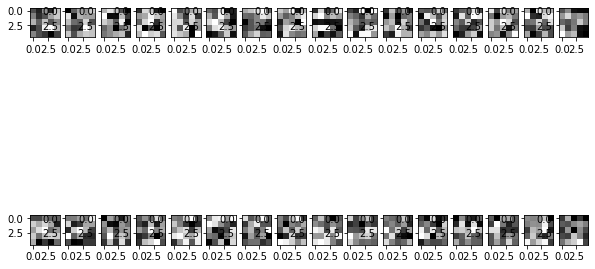

In [157]:
x1w = model.get_weights()[2][:,:,2,:]
ct = 1
f = plt.figure(figsize=(10,7))
for i in range(32):
    # ax = plt.figure(figsize=(18, 10)).add_subplot(111)
    f.add_subplot(2,16,ct)
    # plt.figure()
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
    ct+=1
plt.show()

# ann.fit(Xtrain, ytrain_indicator, epochs=5, batch_size=32)

# x1w = x.get_weights()[0][:,:,0,:]
# for i in range(1,26):
#     plt.subplot(5,5,i)
#     plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
# plt.show()

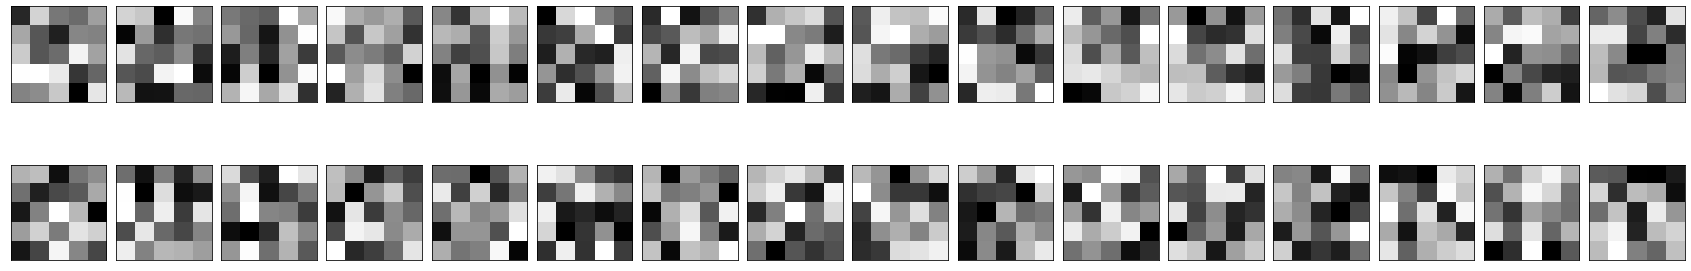

In [152]:
f = plt.figure(figsize=(30,10))
f.subplots_adjust(bottom = 0.1)
ax = f.add_subplot(1, 16, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,0],interpolation="nearest",cmap="gray")
ax = f.add_subplot(1, 16, 2)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,1],interpolation="nearest",cmap="gray")
ax = f.add_subplot(1, 16, 3)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,2],interpolation="nearest",cmap="gray")
ax = f.add_subplot(1, 16, 4)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,3],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 5)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,4],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 6)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,5],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 7)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,6],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 8)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,7],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 9)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,8],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 10)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,9],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 11)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,10],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 12)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,11],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 13)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,12],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 14)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,13],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 15)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,14],interpolation="nearest",cmap="gray")
ax=f.add_subplot(1, 16, 16)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,15],interpolation="nearest",cmap="gray")
plt.subplots_adjust(wspace=0.1, hspace=0, bottom=0)
ax = f.add_subplot(2, 16, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,16],interpolation="nearest",cmap="gray")
ax = f.add_subplot(2, 16, 2)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,17],interpolation="nearest",cmap="gray")
ax = f.add_subplot(2, 16, 3)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,18],interpolation="nearest",cmap="gray")
ax = f.add_subplot(2, 16, 4)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,19],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 5)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,20],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 6)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,21],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 7)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,22],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 8)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,23],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 9)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,24],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 10)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,25],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 11)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,26],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 12)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,27],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 13)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,28],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 14)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,29],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 15)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,30],interpolation="nearest",cmap="gray")
ax=f.add_subplot(2, 16, 16)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x1w[:,:,31],interpolation="nearest",cmap="gray")
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])

In [79]:
print(grads)

<tf.Tensor 'Mean_8:0' shape=() dtype=float32>

In [159]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

